In [1]:
import os, sys, random, pandas as pd, numpy as np
from tqdm import tqdm
import torch


# set random seed
os.environ['CUDA_LAUNCH_BLOCKING'] = '1'
SEED = 10
random.seed(SEED)
np.random.seed(SEED)
torch.random.manual_seed(SEED)
sys.path.append('../')


# load package requirments
from VGFM.utils import  generate_steps, parser, _valid_criterions
from VGFM.plots import plot_comparision
from VGFM.train import pretrain, train
from VGFM.models import  FNet, ODEFunc2
from VGFM.constants import DATA_DIR
from VGFM.exp import setup_exp
from VGFM.eval import generate_plot_data
from torchdiffeq import odeint_adjoint as odeint

### Defining parameters and loading dataset

In [2]:
import torch.optim as optim

dim=1000
f_net = FNet(in_out_dim=dim, hidden_dim=128, n_hiddens=3, activation='leakyrelu')


import sys

# Simulate the command-line arguments
sys.argv = [
    'VGFM Training',
    '-d', 'file',
    '-c', 'ot1',
    '-n', 'gaussian_final',
    '--no-hold-one-out',
    '-ho', '-1',
    '-e1', '500',
    '-e2', '10',
    '-bs', '256',
    '-r', '0.03',
    '-rm', '0.5',
    '--no-norm_cost'
]

args = parser.parse_args()
opts = vars(args)

# Display the parsed arguments
print(opts)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device


{'dataset': 'file', 'time_col': None, 'name': 'gaussian_final', 'output_dir': 'd:\\NeurIPS_2025_VGFM\\VGFM\\results', 'criterion': 'ot1', 'sample_with_replacement': False, 'hold_one_out': False, 'hold_out': -1, 'apply_losses_in_time': True, 'learning_rate1': 0.001, 'epochs1': 500, 'norm_cost': False, 'reg': 0.03, 'reg_m': 0.5, 'n_big_batches': 1, 'n_batch': 256, 'learning_rate2': 0.0001, 'epochs2': 10}


device(type='cpu')

In [3]:
df = pd.read_csv(DATA_DIR + '/gaussian_1000d.csv')
 # make output dir
if not os.path.isdir(opts['output_dir']):
    os.makedirs(opts['output_dir'])
exp_dir, logger = setup_exp(opts['output_dir'], opts, opts['name'])
  # load dataset
logger.info(f'Loading dataset: '+opts['name'])


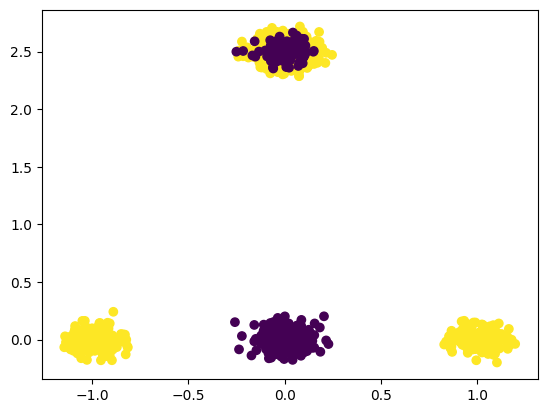

In [4]:
import matplotlib.pyplot as plt
plt.scatter(df.iloc[:,1],df.iloc[:,2],c=df.iloc[:,0])

In [5]:
groups = sorted([g for g in df.samples.unique() if g != args.hold_out])
steps = generate_steps(groups)
optimizer = torch.optim.Adam(f_net.parameters())
opts['criterion']='ot1'
criterion =  _valid_criterions[opts['criterion']]()

# # logger.info(f'Extracting parameters')
use_cuda = torch.cuda.is_available()
# sample_with_replacement = opts['sample_with_replacement' ]
# apply_losses_in_time = opts['apply_losses_in_time']

    
local_losses = {f'{t0}:{t1}':[] for (t0, t1) in steps}
batch_losses = []
globe_losses = []

In [6]:
f_net=f_net.to(device)

In [7]:
initial_size=df[df['samples']==0].x1.shape[0]
initial_size

500

In [8]:
sample_sizes = df.groupby('samples').size()
ref0 = sample_sizes / sample_sizes.iloc[0]  
relative_mass = torch.tensor(ref0.values) 
relative_mass

tensor([1.0000, 2.8000], dtype=torch.float64)

In [9]:
sample_size = (df[df['samples']==0.0].values.shape[0],)

### Training with $\mathcal{L}_{\rm VGFM}$

In [10]:
f_net, v_losses, g_losses, losses = pretrain(
    f_net,
    df,
    optimizer,
    n_epoch=args.epochs1,
    hold_out=args.hold_out,
    logger=logger,
    relative_mass=relative_mass,
    reg=args.reg,
    reg_m=[args.reg_m, np.inf],
    norm_cost=args.norm_cost,
    batch_size=args.n_batch
)


relative_mass tensor([1.0000, 2.8000], dtype=torch.float64)
t_train: [0, 1]


Begin flow and growth matching...: 100%|██████████| 500/500 [00:06<00:00, 76.79epoch/s, loss=0.064320, vloss=0.008569, gloss=0.055751]


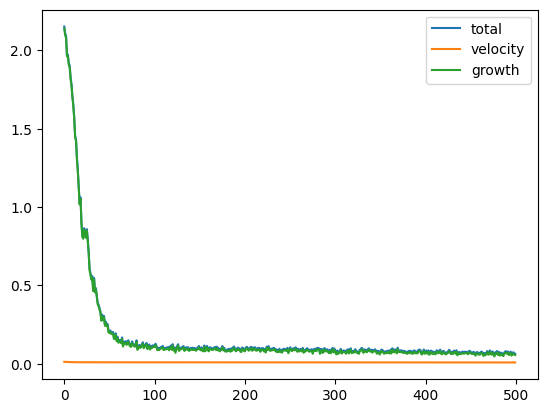

In [11]:
import matplotlib.pyplot as plt
plt.plot(losses,label='total')
plt.plot(v_losses,label='velocity')
plt.plot(g_losses,label='growth')
plt.legend()

In [12]:
torch.save(f_net.state_dict(), os.path.join(exp_dir+'/pretrain_best_model'))

In [13]:
f_net.load_state_dict(torch.load(os.path.join(exp_dir+'/pretrain_best_model'),map_location=torch.device('cpu')))
optimizer = torch.optim.Adam(f_net.parameters(),lr=args.learning_rate2)

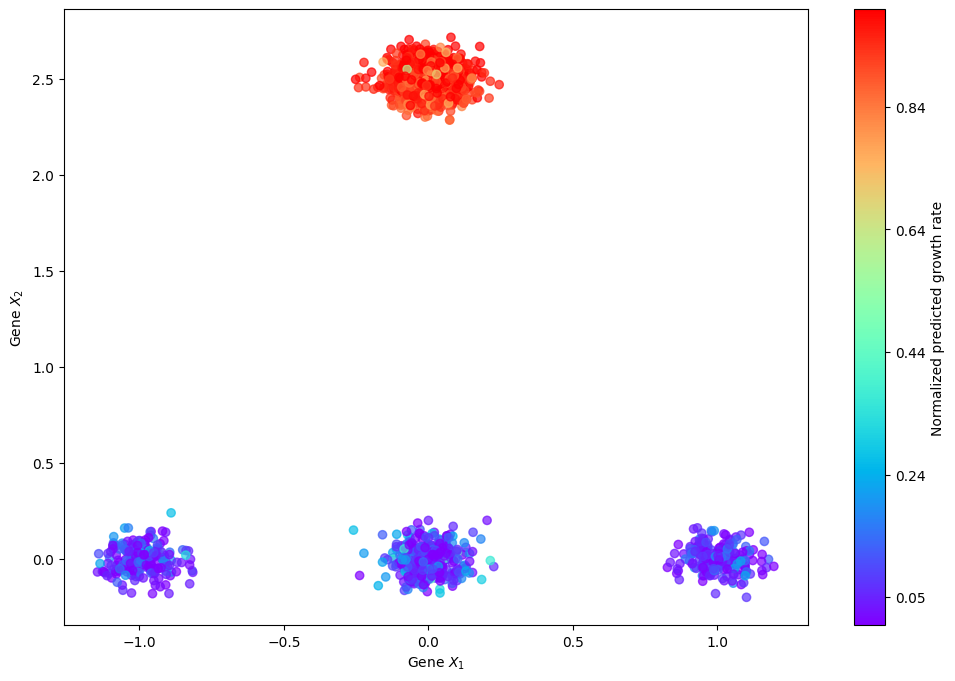

In [14]:
import torch
import matplotlib.pyplot as plt
import numpy as np

def plot_g_values(df, f_net, device=device, output_file='plot.pdf'):
    time_points = df['samples'].unique()
    
    data_by_time = {}
    
    for time in time_points:
        subset = df[df['samples'] == time]
        n = 1000

        column_names = [f'x{i}' for i in range(1, n + 1)]

        tensors = [torch.tensor(subset[col].values, dtype=torch.float32).to(device) for col in column_names]

        data = torch.stack(tensors, dim=1)
        with torch.no_grad():
            t = torch.tensor([time], dtype=torch.float32).to(device)
            _, g = f_net(t, data)
        
        data_by_time[time] = {'data': subset, 'g_values': g.detach().cpu().numpy()}
    
    all_g_values = np.concatenate([content['g_values'] for content in data_by_time.values()])
    
    vmax_value = np.percentile(all_g_values, 90)
    vmin_value = np.percentile(all_g_values, 10)
    
    norm = plt.Normalize(vmin=vmin_value, vmax=vmax_value, clip=True)
    
    fig, ax = plt.subplots(figsize=(12, 8))
    
    for time, content in data_by_time.items():
        subset = content['data']
        g_values = content['g_values']
        x = subset['x1']
        y = subset['x2']
        
        colors = plt.cm.rainbow(norm(g_values))
        
        ax.scatter(x, y, color=colors, label=f'Time {time}', alpha=0.7, marker='o')
    
    ax.set_xlabel('Gene $X_1$')
    ax.set_ylabel('Gene $X_2$')
    
    sm = plt.cm.ScalarMappable(cmap='rainbow', norm=norm)
    sm.set_array(all_g_values)
    cbar = fig.colorbar(sm, ax=ax)
    cbar.set_label('Normalized predicted growth rate')
    
    cbar.ax.yaxis.set_major_formatter(plt.FuncFormatter(lambda x, _: f'{norm(x):.2f}'))
    
    plt.show()

plot_g_values(df, f_net, output_file='gene_growth_pretrain.pdf')

In [15]:
# generate plot data
f_net.to('cpu')
generated, trajectories,_,_ = generate_plot_data(
    f_net, df, n_points=200, n_trajectories=50, n_bins=100, 
    sample_with_replacement=True, use_cuda=use_cuda, samples_key='samples',
    logger=logger
    )


tensor([0., 1.])
<class 'torch.Tensor'>
tensor([0.0000, 0.0101, 0.0202, 0.0303, 0.0404, 0.0505, 0.0606, 0.0707, 0.0808,
        0.0909, 0.1010, 0.1111, 0.1212, 0.1313, 0.1414, 0.1515, 0.1616, 0.1717,
        0.1818, 0.1919, 0.2020, 0.2121, 0.2222, 0.2323, 0.2424, 0.2525, 0.2626,
        0.2727, 0.2828, 0.2929, 0.3030, 0.3131, 0.3232, 0.3333, 0.3434, 0.3535,
        0.3636, 0.3737, 0.3838, 0.3939, 0.4040, 0.4141, 0.4242, 0.4343, 0.4444,
        0.4545, 0.4646, 0.4747, 0.4848, 0.4949, 0.5051, 0.5152, 0.5253, 0.5354,
        0.5455, 0.5556, 0.5657, 0.5758, 0.5859, 0.5960, 0.6061, 0.6162, 0.6263,
        0.6364, 0.6465, 0.6566, 0.6667, 0.6768, 0.6869, 0.6970, 0.7071, 0.7172,
        0.7273, 0.7374, 0.7475, 0.7576, 0.7677, 0.7778, 0.7879, 0.7980, 0.8081,
        0.8182, 0.8283, 0.8384, 0.8485, 0.8586, 0.8687, 0.8788, 0.8889, 0.8990,
        0.9091, 0.9192, 0.9293, 0.9394, 0.9495, 0.9596, 0.9697, 0.9798, 0.9899,
        1.0000])
<class 'torch.Tensor'>


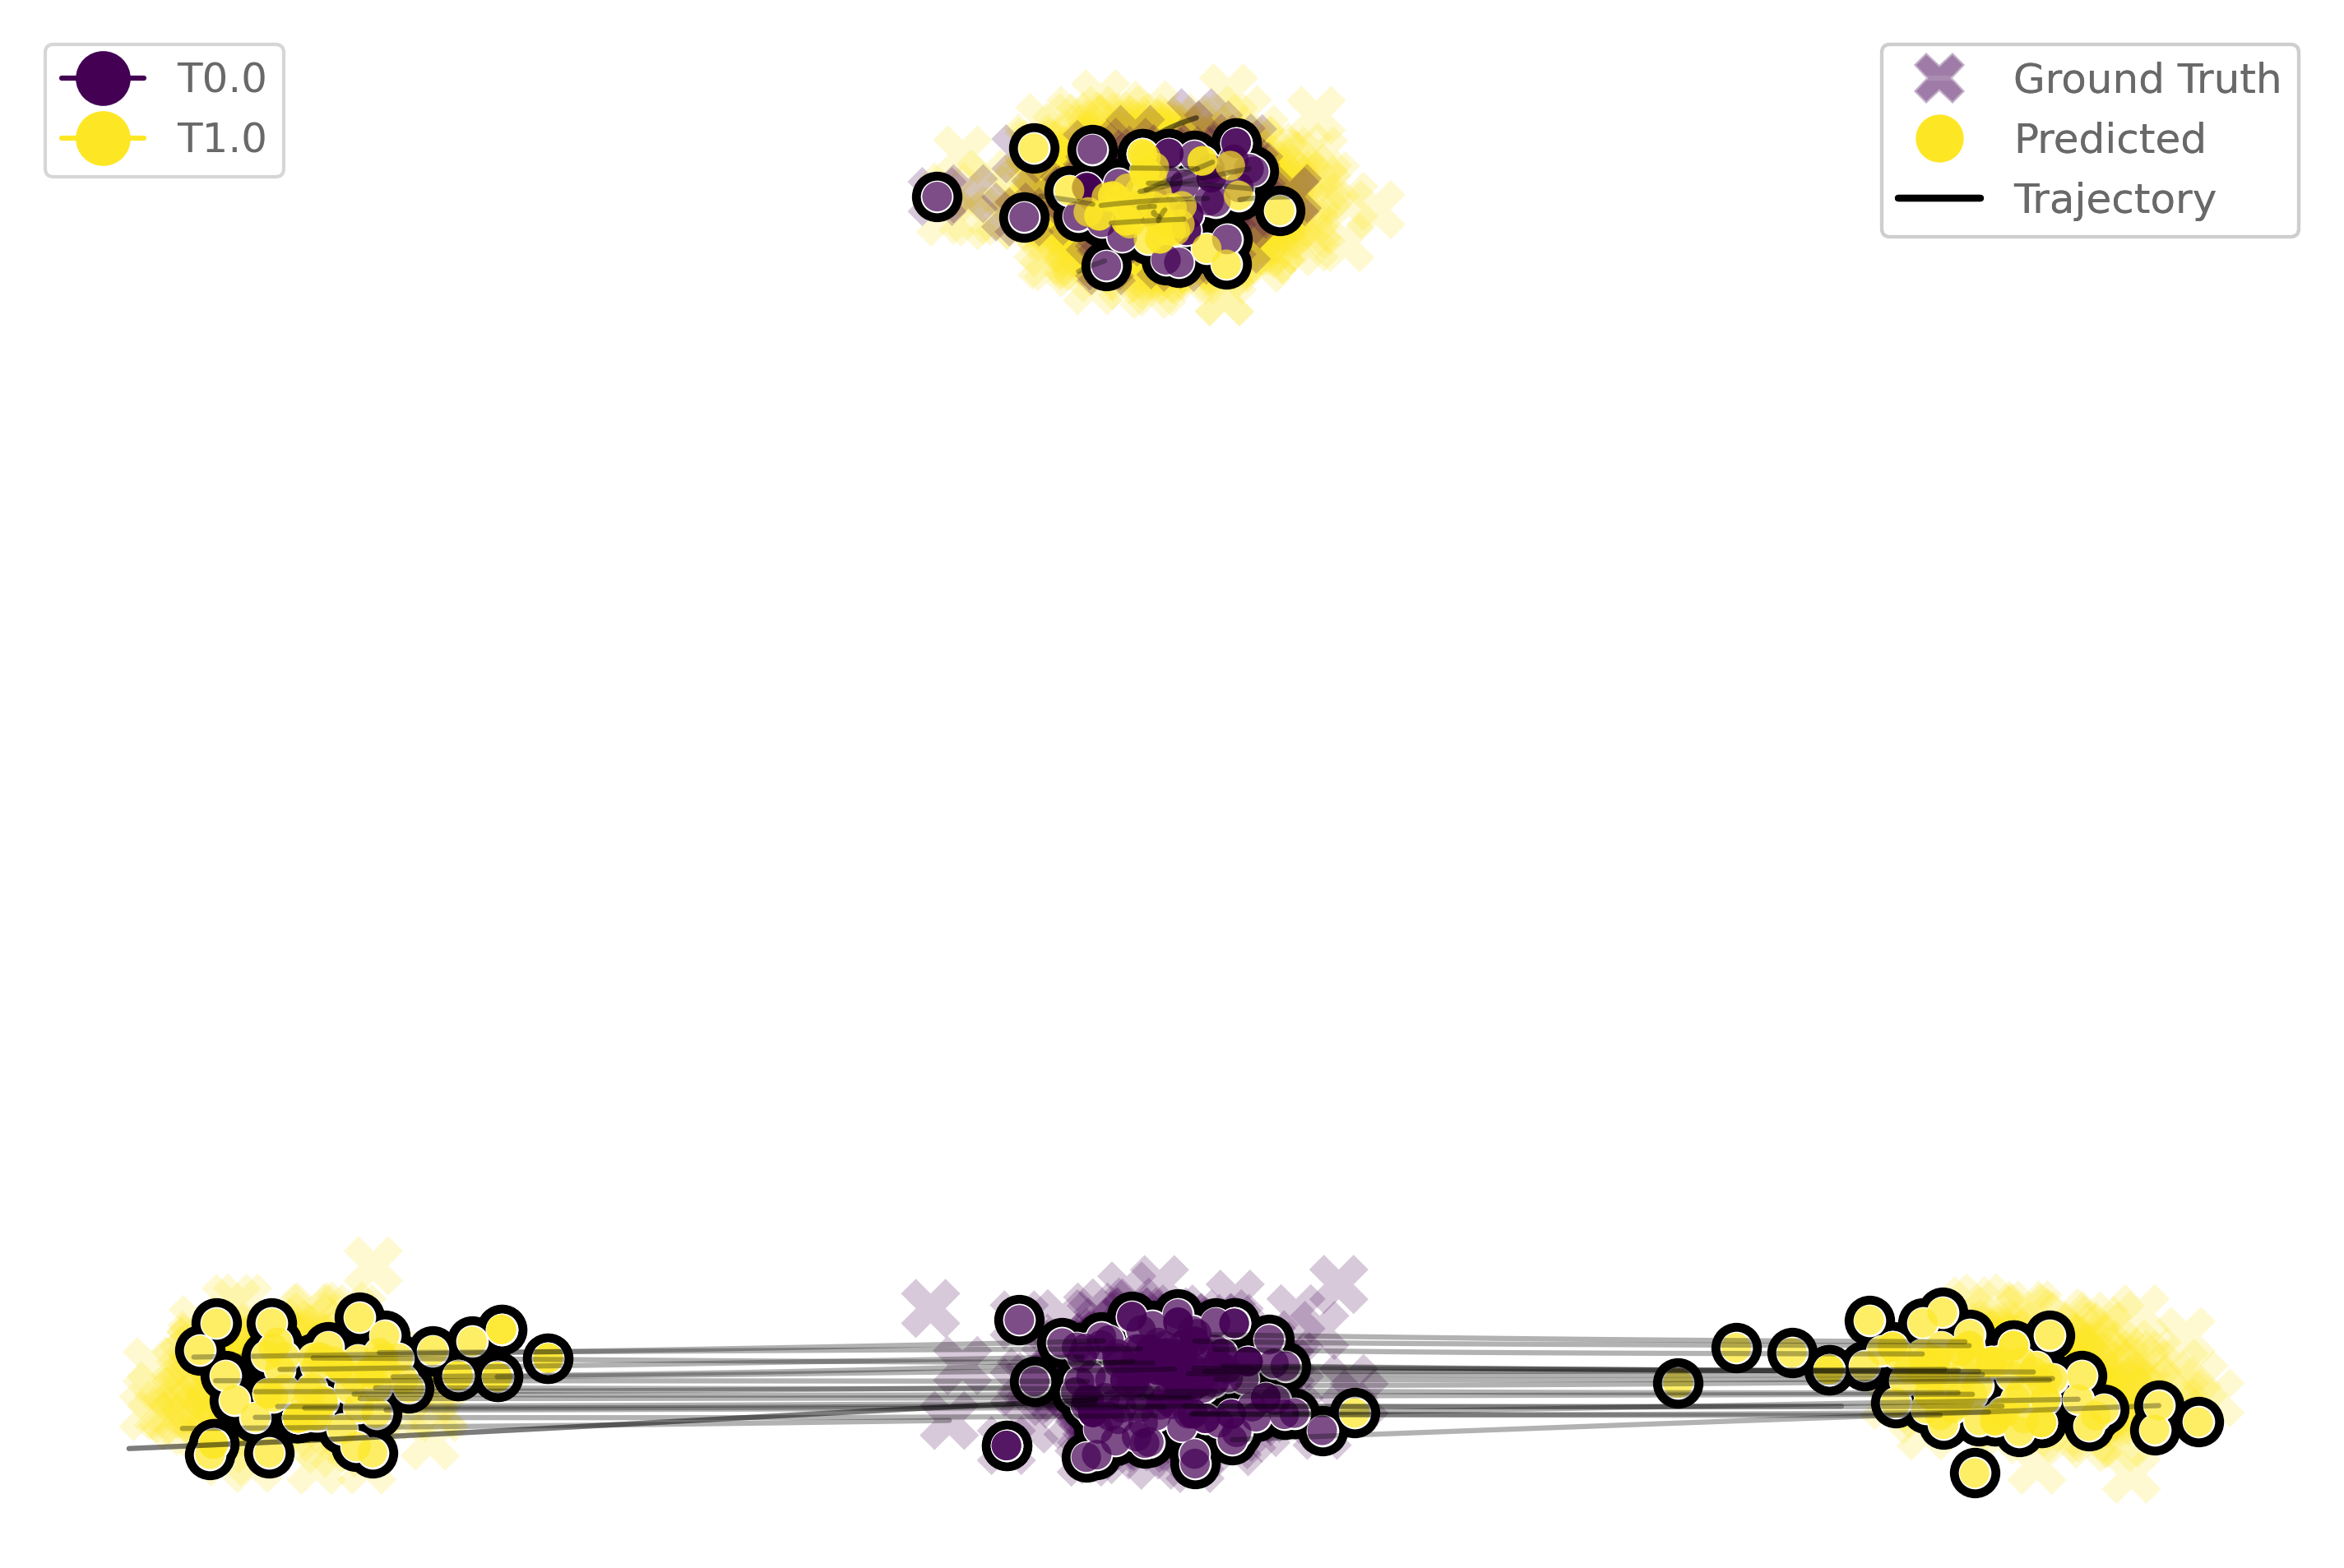

In [16]:
plot_comparision(
    df, generated, trajectories,
    palette = 'viridis', df_time_key='samples',
    save=True, path=exp_dir, file='comparision_pretrain.png',
    x='x1', y='x2', is_3d=False
)

### Incorporating $\mathcal{L}_{\rm OT}$

In [17]:
logger.info("Incorporating $L_{ot}$")

# 训练阶段
l_loss, b_loss, g_loss = train(
    f_net,
    df,
    groups,
    optimizer,
    args.epochs2,  # n_epoch
    criterion=criterion,
    use_cuda=use_cuda,
    apply_losses_in_time=args.apply_losses_in_time,
    hold_one_out=args.hold_one_out,
    hold_out=args.hold_out,
    sample_size=sample_size,
    relative_mass=relative_mass,
    initial_size=initial_size,
    sample_with_replacement=args.sample_with_replacement,
    logger=logger,
    device=device,
    best_model_path=exp_dir + "/best_model",
    stepsize=0.1,
)

# 累积损失
for k, v in l_loss.items():
    local_losses[k].extend(v)

batch_losses.extend(b_loss)
globe_losses.extend(g_loss)


  0%|          | 0/10 [00:00<?, ?it/s]d:\NeurIPS_2025_VGFM\VGFM\notebooks\..\VGFM\train.py:200: UserWarning: Converting a tensor with requires_grad=True to a scalar may lead to unexpected behavior.
Consider using tensor.detach() first. (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\pytorch\torch\csrc\autograd\generated\python_variable_methods.cpp:836.)
  batch_loss = torch.Tensor(batch_loss).float()
 10%|█         | 1/10 [00:00<00:01,  5.63it/s]

epoch_0_0:
relative_mass_pred:2.941662311553955,relative_mass_now:2.8
RME:0.05059368269784117
Otloss:2.84146
total loss:2.84146
New minimum otloss found: 2.841458559036255. Model saved.
epoch_1_0:


 20%|██        | 2/10 [00:00<00:01,  5.62it/s]

relative_mass_pred:2.938080310821533,relative_mass_now:2.8
RME:0.04931439672197621
Otloss:2.83934
total loss:2.83934
New minimum otloss found: 2.839336633682251. Model saved.
epoch_2_0:
relative_mass_pred:2.934544563293457,relative_mass_now:2.8
RME:0.04805162974766329


 30%|███       | 3/10 [00:00<00:01,  5.73it/s]

Otloss:2.83748
total loss:2.83748
New minimum otloss found: 2.837484359741211. Model saved.
epoch_3_0:
relative_mass_pred:2.931126356124878,relative_mass_now:2.8
RME:0.04683084147317076
Otloss:2.83582
total loss:2.83582


 50%|█████     | 5/10 [00:00<00:00,  5.69it/s]

New minimum otloss found: 2.83581805229187. Model saved.
epoch_4_0:
relative_mass_pred:2.927891254425049,relative_mass_now:2.8
RME:0.045675448008946073
Otloss:2.83431
total loss:2.83431
New minimum otloss found: 2.834312677383423. Model saved.


 60%|██████    | 6/10 [00:01<00:00,  5.71it/s]

epoch_5_0:
relative_mass_pred:2.9249138832092285,relative_mass_now:2.8
RME:0.044612101146153105
Otloss:2.83317
total loss:2.83317
New minimum otloss found: 2.833169460296631. Model saved.
epoch_6_0:


 70%|███████   | 7/10 [00:01<00:00,  5.76it/s]

relative_mass_pred:2.922226905822754,relative_mass_now:2.8
RME:0.043652466365269316
Otloss:2.83228
total loss:2.83228
New minimum otloss found: 2.8322789669036865. Model saved.
epoch_7_0:
relative_mass_pred:2.919853925704956,relative_mass_now:2.8
RME:0.0428049734660558


 80%|████████  | 8/10 [00:01<00:00,  5.75it/s]

Otloss:2.83143
total loss:2.83143
New minimum otloss found: 2.8314285278320312. Model saved.
epoch_8_0:
relative_mass_pred:2.9177870750427246,relative_mass_now:2.8
RME:0.04206681251525886
Otloss:2.83061
total loss:2.83061


100%|██████████| 10/10 [00:01<00:00,  5.75it/s]

New minimum otloss found: 2.830605983734131. Model saved.
epoch_9_0:
relative_mass_pred:2.916008710861206,relative_mass_now:2.8
RME:0.0414316824504308
Otloss:2.8298
total loss:2.8298
New minimum otloss found: 2.829801082611084. Model saved.


### Test

In [18]:
f_net.load_state_dict(torch.load(os.path.join(exp_dir+'/best_model'),map_location=torch.device('cpu')))

<All keys matched successfully>

In [19]:
l_loss, b_loss, g_loss = train(
    f_net, df, groups, optimizer, 1, 
    criterion = criterion, use_cuda = use_cuda,
    apply_losses_in_time=args.apply_losses_in_time,
    hold_one_out=args.hold_one_out, hold_out=args.hold_out, 
    sample_size = sample_size,relative_mass=relative_mass,initial_size=initial_size,
    sample_with_replacement = args.sample_with_replacement, logger=logger, device=device, best_model_path=exp_dir+'/test_model',stepsize=0.1
)

100%|██████████| 1/1 [00:00<00:00,  5.79it/s]

epoch_0_0:
relative_mass_pred:2.9144978523254395,relative_mass_now:2.8
RME:0.04089209011622844
Otloss:2.82901
total loss:2.82901
New minimum otloss found: 2.829010009765625. Model saved.


In [20]:
# generate plot data
f_net.to('cpu')
generated, trajectories,generated_weights,trajectories_weights = generate_plot_data(
    f_net, df, n_points=200, n_trajectories=50, n_bins=100, 
    sample_with_replacement=True, use_cuda=use_cuda, samples_key='samples',
    logger=logger
    )


tensor([0., 1.])
<class 'torch.Tensor'>
tensor([0.0000, 0.0101, 0.0202, 0.0303, 0.0404, 0.0505, 0.0606, 0.0707, 0.0808,
        0.0909, 0.1010, 0.1111, 0.1212, 0.1313, 0.1414, 0.1515, 0.1616, 0.1717,
        0.1818, 0.1919, 0.2020, 0.2121, 0.2222, 0.2323, 0.2424, 0.2525, 0.2626,
        0.2727, 0.2828, 0.2929, 0.3030, 0.3131, 0.3232, 0.3333, 0.3434, 0.3535,
        0.3636, 0.3737, 0.3838, 0.3939, 0.4040, 0.4141, 0.4242, 0.4343, 0.4444,
        0.4545, 0.4646, 0.4747, 0.4848, 0.4949, 0.5051, 0.5152, 0.5253, 0.5354,
        0.5455, 0.5556, 0.5657, 0.5758, 0.5859, 0.5960, 0.6061, 0.6162, 0.6263,
        0.6364, 0.6465, 0.6566, 0.6667, 0.6768, 0.6869, 0.6970, 0.7071, 0.7172,
        0.7273, 0.7374, 0.7475, 0.7576, 0.7677, 0.7778, 0.7879, 0.7980, 0.8081,
        0.8182, 0.8283, 0.8384, 0.8485, 0.8586, 0.8687, 0.8788, 0.8889, 0.8990,
        0.9091, 0.9192, 0.9293, 0.9394, 0.9495, 0.9596, 0.9697, 0.9798, 0.9899,
        1.0000])
<class 'torch.Tensor'>


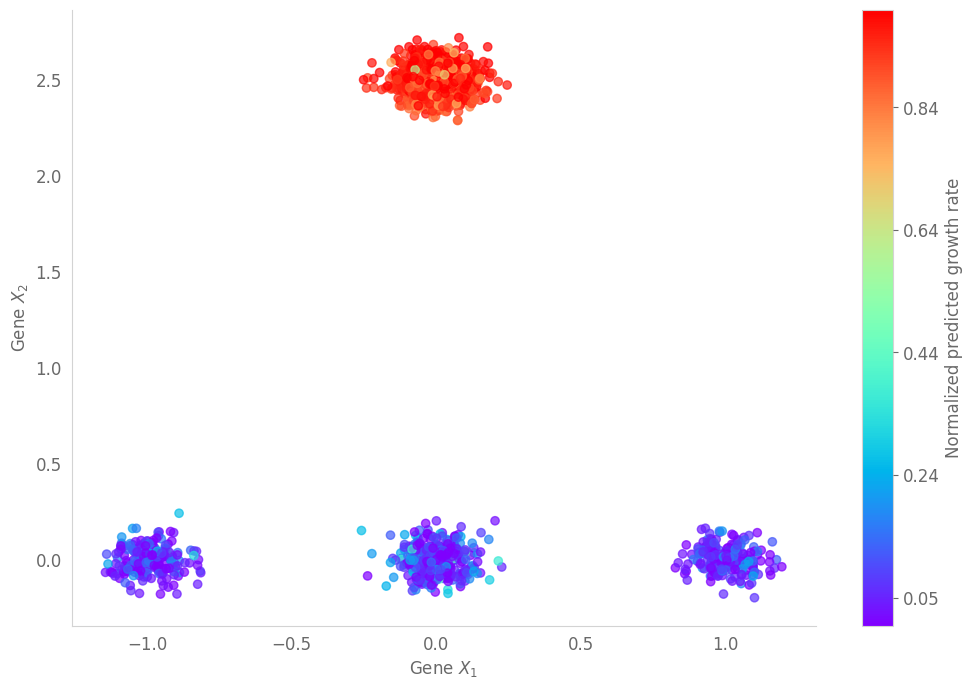

In [ ]:
import torch
import matplotlib.pyplot as plt
import numpy as np

def plot_g_values(df, f_net, device=device, output_file='plot.pdf'):
    time_points = df['samples'].unique()
    
    data_by_time = {}
    
    for time in time_points:
        subset = df[df['samples'] == time]
        n = 1000

        column_names = [f'x{i}' for i in range(1, n + 1)]

        tensors = [torch.tensor(subset[col].values, dtype=torch.float32).to(device) for col in column_names]

        data = torch.stack(tensors, dim=1)
        with torch.no_grad():
            t = torch.tensor([time], dtype=torch.float32).to(device)
            _, g = f_net(t, data)
        
        data_by_time[time] = {'data': subset, 'g_values': g.detach().cpu().numpy()}
    
    all_g_values = np.concatenate([content['g_values'] for content in data_by_time.values()])
    
    vmax_value = np.percentile(all_g_values, 90)
    vmin_value = np.percentile(all_g_values, 10)
    
    norm = plt.Normalize(vmin=vmin_value, vmax=vmax_value, clip=True)
    
    fig, ax = plt.subplots(figsize=(12, 8))
    
    for time, content in data_by_time.items():
        subset = content['data']
        g_values = content['g_values']
        x = subset['x1']
        y = subset['x2']
        
        colors = plt.cm.rainbow(norm(g_values))
        
        ax.scatter(x, y, color=colors, label=f'Time {time}', alpha=0.7, marker='o')
    
    ax.set_xlabel('Gene $X_1$')
    ax.set_ylabel('Gene $X_2$')
    
    sm = plt.cm.ScalarMappable(cmap='rainbow', norm=norm)
    sm.set_array(all_g_values)
    cbar = fig.colorbar(sm, ax=ax)
    cbar.set_label('Normalized predicted growth rate')
    
    cbar.ax.yaxis.set_major_formatter(plt.FuncFormatter(lambda x, _: f'{norm(x):.2f}'))
    
    plt.show()

plot_g_values(df, f_net, output_file='gene_growth_final.pdf')

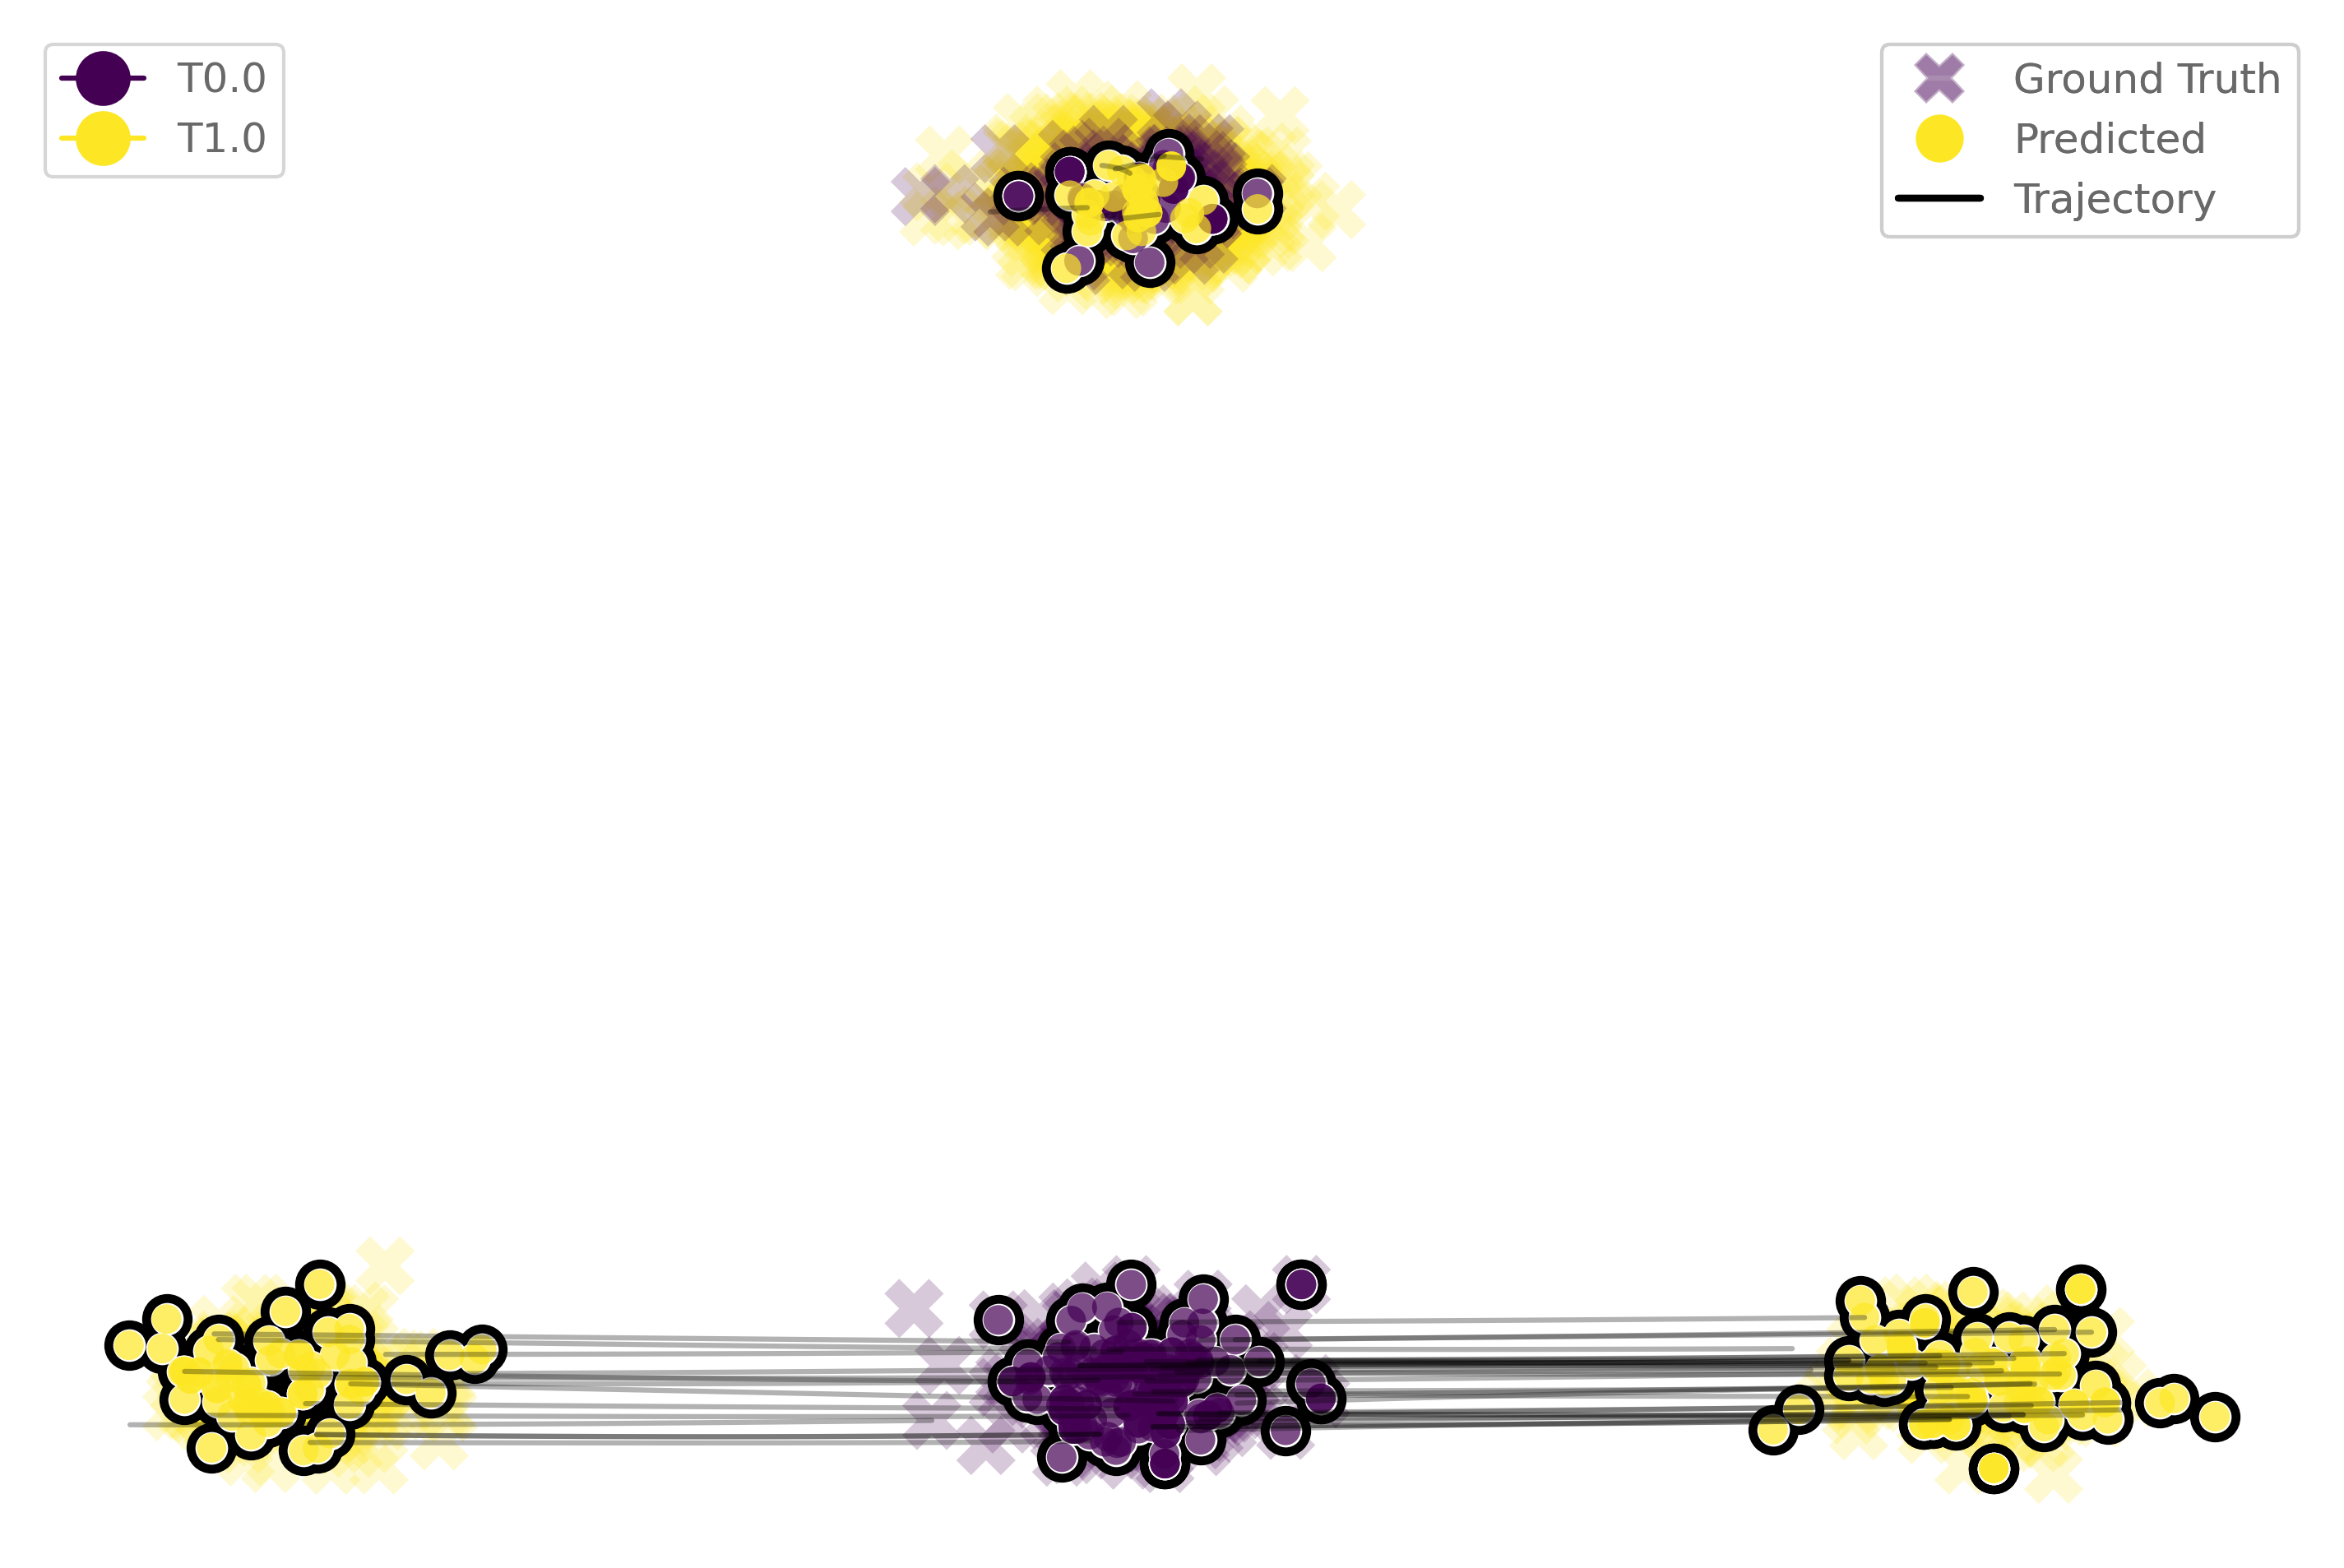

In [22]:
plot_comparision(
    df, generated, trajectories,
    palette = 'viridis', df_time_key='samples',
    save=True, path=exp_dir, file='comparision_final.png',
    x='x1', y='x2', is_3d=False
)